In [1]:
import numpy as np
from scipy import sparse
import pandas as pd
import xgboost as xgb
import re
import string
import time
import seaborn as sns
import itertools

from sklearn import preprocessing, pipeline, metrics, model_selection
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import matplotlib.pyplot as plt

%matplotlib inline 


In [2]:
train_data = pd.read_json('../input/two-sigma-connect-rental-listing-inquiries/train.json.zip', convert_dates=['created'])
test_data = pd.read_json('../input/two-sigma-connect-rental-listing-inquiries/test.json.zip', convert_dates=['created'])

In [3]:
train_size = train_data.shape[0]

## Create target variables

We need to convert the raw target variable into numeric

In [4]:
train_data['target'] = train_data['interest_level'].apply(lambda x: 0 if x=='low' else 1 if x=='medium' else 2)
train_data['low'] = train_data['interest_level'].apply(lambda x: 1 if x=='low' else 0)
train_data['medium'] = train_data['interest_level'].apply(lambda x: 1 if x=='medium' else 0)
train_data['high'] = train_data['interest_level'].apply(lambda x: 1 if x=='high' else 0)

## Merge training and testing data
So we don't have to perform transformations twice

In [5]:
full_data=pd.concat([train_data,test_data])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


## Group variables

In [6]:
num_vars = ['bathrooms','bedrooms','latitude','longitude','price']
cat_vars = ['building_id','manager_id','display_address','street_address']
text_vars = ['description','features']
date_var = 'created'
image_var = 'photos'
id_var = 'listing_id'

## Date/time features

In [7]:
full_data['created_datetime'] = pd.to_datetime(full_data['created'], format="%Y-%m-%d %H:%M:%S")
full_data['created_year']=full_data['created_datetime'].apply(lambda x:x.year) ## low variant
full_data['created_datetime'] = pd.to_datetime(full_data['created'], format="%Y-%m-%d %H:%M:%S")
full_data['created_month']=full_data['created_datetime'].apply(lambda x:x.month)
full_data['created_day']=full_data['created_datetime'].apply(lambda x:x.day)
full_data['created_dayofweek']=full_data['created_datetime'].apply(lambda x:x.dayofweek)
full_data['created_dayofyear']=full_data['created_datetime'].apply(lambda x:x.dayofyear)
full_data['created_weekofyear']=full_data['created_datetime'].apply(lambda x:x.weekofyear)
full_data['created_hour']=full_data['created_datetime'].apply(lambda x:x.hour)
full_data['created_epoch']=full_data['created_datetime'].apply(lambda x:x.value//10**9)

date_num_vars = ['created_month','created_dayofweek','created_dayofyear'
                 ,'created_weekofyear','created_hour','created_epoch']

## Geolocation features

In [8]:
full_data["geo_area_50"] = \
    full_data[['latitude', 'longitude']]\
    .apply(lambda x:(int(x[0]*50)%50)*50+(int(-x[1]*50)%50),axis=1)                                         
                         

full_data["geo_area_100"] = \
    full_data[['latitude', 'longitude']]\
    .apply(lambda x:(int(x[0]*100)%100)*100+(int(-x[1]*100)%100),axis=1)                                         
  

full_data["geo_area_200"] = \
    full_data[['latitude', 'longitude']]\
    .apply(lambda x:(int(x[0]*200)%200)*200+(int(-x[1]*200)%200),axis=1)                                         

import math

# Financial district
lat=40.705628
lon=-74.010278
full_data['distance_to_fi'] = full_data[['latitude', 'longitude']].apply(lambda x:math.sqrt((x[0]-lat)**2+(x[1]-lon)**2), axis=1)

# Central park
lat = 40.785091
lon = -73.968285
full_data['distance_to_cp'] = full_data[['latitude', 'longitude']].apply(lambda x:math.sqrt((x[0]-lat)**2+(x[1]-lon)**2), axis=1)


geo_cat_vars = ['geo_area_50', 'geo_area_100', 'geo_area_200']

geo_num_vars = ['distance_to_fi', 'distance_to_cp']

## Numeric features: basic engineering

In [9]:
full_data['rooms'] = full_data['bedrooms'] + full_data['bathrooms'] 
full_data['num_of_photos'] = full_data['photos'].apply(lambda x:len(x))
full_data['num_of_features'] = full_data['features'].apply(lambda x:len(x))
full_data['len_of_desc'] = full_data['description'].apply(lambda x:len(x))
full_data['words_of_desc'] = full_data['description'].apply(lambda x:len(re.sub('['+string.punctuation+']', '', x).split()))


full_data['nums_of_desc'] = full_data['description']\
        .apply(lambda x:re.sub('['+string.punctuation+']', '', x).split())\
        .apply(lambda x: len([s for s in x if s.isdigit()]))
        
full_data['has_phone'] = full_data['description'].apply(lambda x:re.sub('['+string.punctuation+']', '', x).split())\
        .apply(lambda x: [s for s in x if s.isdigit()])\
        .apply(lambda x: len([s for s in x if len(str(s))==10]))\
        .apply(lambda x: 1 if x>0 else 0)
full_data['has_email'] = full_data['description'].apply(lambda x: 1 if '@renthop.com' in x else 0)

full_data['building_id_is_zero'] = full_data['building_id'].apply(lambda x:1 if x=='0' else 0)

additional_num_vars = ['rooms','num_of_photos','num_of_features','len_of_desc',
                    'words_of_desc','has_phone','has_email','building_id_is_zero']

## Numeric-Numeric interactions

In [10]:
full_data['avg_word_len'] = full_data[['len_of_desc','words_of_desc']]\
                                    .apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
    
full_data['price_per_room'] = full_data[['price','rooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['price_per_bedroom'] = full_data[['price','bedrooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['price_per_bathroom'] = full_data[['price','bathrooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['price_per_feature'] = full_data[['price','num_of_features']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['price_per_photo'] = full_data[['price','num_of_photos']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['price_per_word'] = full_data[['price','words_of_desc']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['price_by_desc_len'] = full_data[['price','len_of_desc']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)


full_data['photos_per_room'] = full_data[['num_of_photos','rooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['photos_per_bedroom'] = full_data[['num_of_photos','bedrooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['photos_per_bathroom'] = full_data[['num_of_photos','bathrooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)

full_data['desc_len_per_room'] = full_data[['len_of_desc','rooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['desc_len_per_bedroom'] = full_data[['len_of_desc','bedrooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['desc_len_per_bathroom'] = full_data[['len_of_desc','bathrooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['desc_len_per_word'] = full_data[['len_of_desc','words_of_desc']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['desc_len_per_numeric'] = full_data[['len_of_desc','nums_of_desc']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)

full_data['features_per_room'] = full_data[['num_of_features','rooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['features_per_bedroom'] = full_data[['num_of_features','bedrooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['features_per_bathroom'] = full_data[['num_of_features','bathrooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['features_per_photo'] = full_data[['num_of_features','num_of_photos']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['features_per_word'] = full_data[['num_of_features','words_of_desc']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
full_data['features_by_desc_len'] = full_data[['num_of_features','len_of_desc']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)


interactive_num_vars = ['avg_word_len','price_per_room','price_per_bedroom','price_per_bathroom',
                        'price_per_feature','price_per_photo','price_per_word','price_by_desc_len',
                        'photos_per_room','photos_per_bedroom','photos_per_bathroom',
                        'desc_len_per_room','desc_len_per_bedroom','desc_len_per_bathroom','desc_len_per_word',
                        'desc_len_per_numeric','features_per_room','features_per_bedroom','features_per_bathroom',
                        'features_per_photo','features_per_word','features_by_desc_len']

## Count features

In [11]:
%%time
display=full_data["display_address"].value_counts()
manager_id=full_data["manager_id"].value_counts()
building_id=full_data["building_id"].value_counts()
street=full_data["street_address"].value_counts()
bedrooms=full_data["bedrooms"].value_counts()
bathrooms=full_data["bathrooms"].value_counts()
created_dayofyear=full_data["created_dayofyear"].value_counts()
created_weekofyear=full_data["created_weekofyear"].value_counts()

full_data["display_count"]=full_data["display_address"].apply(lambda x:display[x])
full_data["manager_count"]=full_data["manager_id"].apply(lambda x:manager_id[x])  
full_data["building_count"]=full_data["building_id"].apply(lambda x:building_id[x])
full_data["street_count"]=full_data["street_address"].apply(lambda x:street[x])
full_data["bedrooms_count"]=full_data["bedrooms"].apply(lambda x:bedrooms[x])
full_data["bathrooms_count"]=full_data["bathrooms"].apply(lambda x:bathrooms[x])
full_data["created_dayofyear_count"]=full_data["created_dayofyear"].\
    apply(lambda x:created_dayofyear[x])
full_data["created_weekofyear_count"]=full_data["created_weekofyear"].\
    apply(lambda x:created_weekofyear[x])

count_vars = ['manager_count', 'building_count', 'street_count', 'bedrooms_count',
       'bathrooms_count', 'created_dayofyear_count', 'created_weekofyear_count']

CPU times: user 17.5 s, sys: 2.91 ms, total: 17.5 s
Wall time: 17.5 s


## Numeric-categorical interactions

In [12]:
num_cat_vars =[]
price_by_manager = full_data.groupby('manager_id')['price'].agg([np.min,np.max,np.median,np.mean]).reset_index()
price_by_manager.columns = ['manager_id','min_price_by_manager',
                            'max_price_by_manager','median_price_by_manager','mean_price_by_manager']
full_data = pd.merge(full_data,price_by_manager, how='left',on='manager_id')

price_by_building = full_data.groupby('building_id')['price'].agg([np.min,np.max,np.median,np.mean]).reset_index()
price_by_building.columns = ['building_id','min_price_by_building',
                            'max_price_by_building','median_price_by_building','mean_price_by_building']
full_data = pd.merge(full_data,price_by_building, how='left',on='building_id')


full_data['price_percentile_by_manager']=\
            full_data[['price','min_price_by_manager','max_price_by_manager']]\
            .apply(lambda x:(x[0]-x[1])/(x[2]-x[1]) if (x[2]-x[1])!=0 else 0.5,
                  axis=1)
full_data['price_percentile_by_building']=\
            full_data[['price','min_price_by_building','max_price_by_building']]\
            .apply(lambda x:(x[0]-x[1])/(x[2]-x[1]) if (x[2]-x[1])!=0 else 0.5,
                  axis=1)


num_cat_vars.append('price_percentile_by_manager')
num_cat_vars.append('price_percentile_by_building')

print (num_cat_vars)

['price_percentile_by_manager', 'price_percentile_by_building']


## Two-way categorical features interactions

In [13]:
for comb in itertools.combinations(cat_vars, 2):
    comb_var_name = comb[0] +'-'+ comb[1]
    full_data [comb_var_name] = full_data [ comb[0]].astype(str) +'_' + full_data [ comb[1]].astype(str)
    cat_vars.append(comb_var_name)

cat_vars    

['building_id',
 'manager_id',
 'display_address',
 'street_address',
 'building_id-manager_id',
 'building_id-display_address',
 'building_id-street_address',
 'manager_id-display_address',
 'manager_id-street_address',
 'display_address-street_address']

## Text features

* Here we are using CountVectorizer but you are encouraged to give TfidfVectorizer a try.

* The parameter of max_features to be tuned

* The outputs are sparse matrices which can be merged with numpy arrays using scipy.stats.sparse.hstack function


In [14]:
full_data["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
cntvec = CountVectorizer(stop_words='english', max_features=200)
feature_sparse =cntvec.fit_transform(full_data["features"]\
                                     .apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x])))

feature_vars = ['feature_' + v for v in cntvec.vocabulary_]

cntvec = CountVectorizer(stop_words='english', max_features=100)
desc_sparse = cntvec.fit_transform(full_data["description"])
desc_vars = ['desc_' + v for v in cntvec.vocabulary_]


cntvec = CountVectorizer(stop_words='english', max_features=10)
st_addr_sparse = cntvec.fit_transform(full_data["street_address"])
st_addr_vars = ['desc_' + v for v in cntvec.vocabulary_]

## Categorical features - label encoding

In [15]:
LBL = preprocessing.LabelEncoder()

LE_vars=[]
LE_map=dict()
for cat_var in cat_vars:
    print ("Label Encoding %s" % (cat_var))
    LE_var=cat_var+'_le'
    full_data[LE_var]=LBL.fit_transform(full_data[cat_var])
    LE_vars.append(LE_var)
    LE_map[cat_var]=LBL.classes_
    
print ("Label-encoded feaures: %s" % (LE_vars))

Label Encoding building_id
Label Encoding manager_id
Label Encoding display_address
Label Encoding street_address
Label Encoding building_id-manager_id
Label Encoding building_id-display_address
Label Encoding building_id-street_address
Label Encoding manager_id-display_address
Label Encoding manager_id-street_address
Label Encoding display_address-street_address
Label-encoded feaures: ['building_id_le', 'manager_id_le', 'display_address_le', 'street_address_le', 'building_id-manager_id_le', 'building_id-display_address_le', 'building_id-street_address_le', 'manager_id-display_address_le', 'manager_id-street_address_le', 'display_address-street_address_le']


## Categorical features - one hot encoding

The output is a sparse matrix

In [16]:
OHE = preprocessing.OneHotEncoder(sparse=True)
start=time.time()
OHE.fit(full_data[LE_vars])
OHE_sparse=OHE.transform(full_data[LE_vars])
                                   
print ('One-hot-encoding finished in %f seconds' % (time.time()-start))


OHE_vars = [var[:-3] + '_' + str(level).replace(' ','_')\
                for var in cat_vars for level in LE_map[var] ]

print ("OHE_sparse size :" ,OHE_sparse.shape)
print ("One-hot encoded catgorical feature samples : %s" % (OHE_vars[:100]))

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


One-hot-encoding finished in 0.843020 seconds
OHE_sparse size : (124011, 340241)
One-hot encoded catgorical feature samples : ['building_0', 'building_00005cb939f9986300d987652c933e15', 'building_00024d77a43f0606f926e2312513845c', 'building_000ae4b7db298401cdae2b0ba1ea8146', 'building_0012f1955391bca600ec301035b97b65', 'building_0021440c04241281a436ec21accc40b1', 'building_002d1eba40aa0a6610e04ff20543585f', 'building_003d8740e21484dcc2280639b25539a4', 'building_00480e54b53fe77d17964be3f8307a99', 'building_00553d95d22484bcc36831c9248d1dbc', 'building_0055c8662ba19e95f78df97592d2b83e', 'building_0056dbdf2881b76f2a0171eb753ec9e0', 'building_0059ae562b9e338a59eaf962cb3eedd2', 'building_005e0f8d7fb7b92be351cbf1dd985149', 'building_0067f166111490e7af7f1a878a67bb5e', 'building_0070bc94a3f80aa717bb15708e98ba54', 'building_0071cda335745940cdae1dc31abfc701', 'building_0078281cd69f4bfec17e42e5cf5eecd9', 'building_0078c2ab46afba9969637ac83621901e', 'building_007ae1cd90420f18bad7b6892a9a1411', 'bui

## Categorical features - mean encoding

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from itertools import product

class MeanEncoder:
    def __init__(self, categorical_features, n_splits=5, target_type='classification', prior_weight_func=None):
        """
        :param categorical_features: list of str, the name of the categorical columns to encode

        :param n_splits: the number of splits used in mean encoding

        :param target_type: str, 'regression' or 'classification'

        :param prior_weight_func:
        a function that takes in the number of observations, and outputs prior weight
        when a dict is passed, the default exponential decay function will be used:
        k: the number of observations needed for the posterior to be weighted equally as the prior
        f: larger f --> smaller slope
        """

        self.categorical_features = categorical_features
        self.n_splits = n_splits
        self.learned_stats = {}

        if target_type == 'classification':
            self.target_type = target_type
            self.target_values = []
        else:
            self.target_type = 'regression'
            self.target_values = None

        if isinstance(prior_weight_func, dict):
            self.prior_weight_func = eval('lambda x: 1 / (1 + np.exp((x - k) / f))', dict(prior_weight_func, np=np))
        elif callable(prior_weight_func):
            self.prior_weight_func = prior_weight_func
        else:
            self.prior_weight_func = lambda x: 1 / (1 + np.exp((x - 2) / 1))

    @staticmethod
    def mean_encode_subroutine(X_train, y_train, X_test, variable, target, prior_weight_func):
        X_train = X_train[[variable]].copy()
        X_test = X_test[[variable]].copy()

        if target is not None:
            nf_name = '{}_pred_{}'.format(variable, target)
            X_train['pred_temp'] = (y_train == target).astype(int)  # classification
        else:
            nf_name = '{}_pred'.format(variable)
            X_train['pred_temp'] = y_train  # regression
        prior = X_train['pred_temp'].mean()

        col_avg_y = X_train.groupby(by=variable, axis=0)['pred_temp'].agg({'mean': 'mean', 'beta': 'size'})
        col_avg_y['beta'] = prior_weight_func(col_avg_y['beta'])
        col_avg_y[nf_name] = col_avg_y['beta'] * prior + (1 - col_avg_y['beta']) * col_avg_y['mean']
        col_avg_y.drop(['beta', 'mean'], axis=1, inplace=True)

        nf_train = X_train.join(col_avg_y, on=variable)[nf_name].values
        nf_test = X_test.join(col_avg_y, on=variable).fillna(prior, inplace=False)[nf_name].values

        return nf_train, nf_test, prior, col_avg_y

    def fit_transform(self, X, y):
        """
        :param X: pandas DataFrame, n_samples * n_features
        :param y: pandas Series or numpy array, n_samples
        :return X_new: the transformed pandas DataFrame containing mean-encoded categorical features
        """
        X_new = X.copy()
        if self.target_type == 'classification':
            skf = StratifiedKFold(self.n_splits)
        else:
            skf = KFold(self.n_splits)

        if self.target_type == 'classification':
            self.target_values = sorted(set(y))
            self.learned_stats = {'{}_pred_{}'.format(variable, target): [] for variable, target in
                                  product(self.categorical_features, self.target_values)}
            for variable, target in product(self.categorical_features, self.target_values):
                nf_name = '{}_pred_{}'.format(variable, target)
                X_new.loc[:, nf_name] = np.nan
                for large_ind, small_ind in skf.split(y, y):
                    nf_large, nf_small, prior, col_avg_y = MeanEncoder.mean_encode_subroutine(
                        X_new.iloc[large_ind], y.iloc[large_ind], X_new.iloc[small_ind], variable, target, self.prior_weight_func)
                    X_new.iloc[small_ind, -1] = nf_small
                    self.learned_stats[nf_name].append((prior, col_avg_y))
        else:
            self.learned_stats = {'{}_pred'.format(variable): [] for variable in self.categorical_features}
            for variable in self.categorical_features:
                nf_name = '{}_pred'.format(variable)
                X_new.loc[:, nf_name] = np.nan
                for large_ind, small_ind in skf.split(y, y):
                    nf_large, nf_small, prior, col_avg_y = MeanEncoder.mean_encode_subroutine(
                        X_new.iloc[large_ind], y.iloc[large_ind], X_new.iloc[small_ind], variable, None, self.prior_weight_func)
                    X_new.iloc[small_ind, -1] = nf_small
                    self.learned_stats[nf_name].append((prior, col_avg_y))
        return X_new

    def transform(self, X):
        """
        :param X: pandas DataFrame, n_samples * n_features
        :return X_new: the transformed pandas DataFrame containing mean-encoded categorical features
        """
        X_new = X.copy()

        if self.target_type == 'classification':
            for variable, target in product(self.categorical_features, self.target_values):
                nf_name = '{}_pred_{}'.format(variable, target)
                X_new[nf_name] = 0
                for prior, col_avg_y in self.learned_stats[nf_name]:
                    X_new[nf_name] += X_new[[variable]].join(col_avg_y, on=variable).fillna(prior, inplace=False)[
                        nf_name]
                X_new[nf_name] /= self.n_splits
        else:
            for variable in self.categorical_features:
                nf_name = '{}_pred'.format(variable)
                X_new[nf_name] = 0
                for prior, col_avg_y in self.learned_stats[nf_name]:
                    X_new[nf_name] += X_new[[variable]].join(col_avg_y, on=variable).fillna(prior, inplace=False)[
                        nf_name]
                X_new[nf_name] /= self.n_splits

        return X_new

In [18]:
mean_encoder = MeanEncoder(categorical_features=['manager_id','building_id'])
mean_encoded_train = mean_encoder.fit_transform(train_data, train_data['target'])
mean_encoded_test = mean_encoder.transform(test_data)

mean_coded_vars = list(set(mean_encoded_train.columns) - set(train_data.columns))
mean_coded_vars.append('listing_id')
full_data = pd.merge(full_data, 
                     pd.concat([mean_encoded_train[mean_coded_vars], mean_encoded_test[mean_coded_vars]]),
                     how='left',
                     on='listing_id'
                    )

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:53: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:53: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:53: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:53: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version.

## Baseline

In [19]:
full_vars = num_vars + date_num_vars + additional_num_vars + interactive_num_vars+ geo_cat_vars +geo_num_vars+ count_vars + LE_vars + mean_coded_vars
train_x = sparse.hstack([full_data[full_vars], 
                         feature_sparse, 
                         desc_sparse, 
                         st_addr_sparse]).tocsr()[:train_size]
train_y = full_data['target'][:train_size].values
test_x = sparse.hstack([full_data[full_vars], 
                        feature_sparse, 
                        desc_sparse, 
                        st_addr_sparse]).tocsr()[train_size:]
test_y = full_data['target'][train_size:].values


full_vars = full_vars + feature_vars + desc_vars + st_addr_vars    
print ("training data size: ", train_x.shape,"testing data size: ", test_x.shape)

training data size:  (49352, 380) testing data size:  (74659, 380)


In [20]:
set(['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price', 'created_month', 'created_dayofweek', 'created_dayofyear', 'created_weekofyear', 'created_hour', 'created_epoch', 'rooms', 'num_of_photos', 'num_of_features', 'len_of_desc', 'words_of_desc', 'has_phone', 'has_email', 'building_id_is_zero', 'avg_word_len', 'price_per_room', 'price_per_bedroom', 'price_per_bathroom', 'price_per_feature', 'price_per_photo', 'price_per_word', 'price_by_desc_len', 'photos_per_room', 'photos_per_bedroom', 'photos_per_bathroom', 'desc_len_per_room', 'desc_len_per_bedroom', 'desc_len_per_bathroom', 'desc_len_per_word', 'desc_len_per_numeric', 'features_per_room', 'features_per_bedroom', 'features_per_bathroom', 'features_per_photo', 'features_per_word', 'features_by_desc_len', 'geo_area_50', 'geo_area_100', 'geo_area_200', 'manager_count', 'building_count', 'street_count', 'bedrooms_count', 'bathrooms_count', 'created_dayofyear_count', 'created_weekofyear_count', 'building_id_le', 'manager_id_le', 'display_address_le', 'street_address_le', 'building_id-manager_id_le', 'building_id-display_address_le', 'building_id-street_address_le', 'manager_id-display_address_le', 'manager_id-street_address_le', 'display_address-street_address_le', 'building_id_pred_1', 'manager_id_pred_2', 'building_id_pred_0', 'building_id_pred_2', 'manager_id_pred_0', 'manager_id_pred_1', 'listing_id'])-set(['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price', 'created_month', 'created_dayofweek', 'created_dayofyear', 'created_weekofyear', 'created_hour', 'created_epoch', 'rooms', 'num_of_photos', 'num_of_features', 'len_of_desc', 'words_of_desc', 'has_phone', 'has_email', 'building_id_is_zero', 'avg_word_len', 'price_per_room', 'price_per_bedroom', 'price_per_bathroom', 'price_per_feature', 'price_per_photo', 'price_per_word', 'price_by_desc_len', 'photos_per_room', 'photos_per_bedroom', 'photos_per_bathroom', 'desc_len_per_room', 'desc_len_per_bedroom', 'desc_len_per_bathroom', 'desc_len_per_word', 'desc_len_per_numeric', 'features_per_room', 'features_per_bedroom', 'features_per_bathroom', 'features_per_photo', 'features_per_word', 'features_by_desc_len', 'norm_listing_id', 'building_id_le', 'manager_id_le', 'display_address_le', 'street_address_le', 'building_id-manager_id_le', 'building_id-display_address_le', 'building_id-street_address_le', 'manager_id-display_address_le', 'manager_id-street_address_le', 'display_address-street_address_le', 'building_id_pred_1', 'manager_id_pred_2', 'building_id_pred_0', 'building_id_pred_2', 'manager_id_pred_0', 'manager_id_pred_1', 'listing_id'])

{'bathrooms_count',
 'bedrooms_count',
 'building_count',
 'created_dayofyear_count',
 'created_weekofyear_count',
 'geo_area_100',
 'geo_area_200',
 'geo_area_50',
 'manager_count',
 'street_count'}

### LightGBM 

Typically, GBDT model converges faster with a larger learning rate (e.g 0.1) than smaller learning rate however the accuracy may not be as promising. We will be using 0.1 as the learning rate for the rest of this notebook.

#### Large learning rate

In [21]:
%%time
import lightgbm as lgb
lgb_params = dict()
lgb_params['objective'] = 'multiclass'
lgb_params['num_class'] = 3
lgb_params['learning_rate'] = 0.1
lgb_params['num_leaves'] = 63
lgb_params['max_depth'] = 15
lgb_params['min_gain_to_split '] = 1
lgb_params['subsample'] = 0.7
lgb_params['colsample_bytree'] = 0.7
lgb_params['min_sum_hessian_in_leaf'] = 0.001
lgb_params['seed']=42

lgb_cv = lgb.cv(lgb_params,
                lgb.Dataset(train_x,
                            label=train_y
                            ),
                num_boost_round=100000,
                nfold=5,
                stratified=True,
                shuffle=True,
                early_stopping_rounds=50,
                seed=42,
                verbose_eval=50)


best_score = min(lgb_cv['multi_logloss-mean'])
best_iteration = len(lgb_cv['multi_logloss-mean'])
print ('Best iteration: %d, best score: %f' % (best_iteration, best_score))
# 0.549718

[50]	cv_agg's multi_logloss: 0.545721 + 0.00447754
[100]	cv_agg's multi_logloss: 0.533822 + 0.0050867
[150]	cv_agg's multi_logloss: 0.532546 + 0.00540632
[200]	cv_agg's multi_logloss: 0.533726 + 0.00491786
Best iteration: 158, best score: 0.532456
CPU times: user 5min 54s, sys: 2.4 s, total: 5min 57s
Wall time: 1min 30s


#### small learning rate

In [22]:
%%time
lgb_params = dict()
lgb_params['objective'] = 'multiclass'
lgb_params['num_class'] = 3
lgb_params['learning_rate'] = 0.05
lgb_params['num_leaves'] = 63
lgb_params['max_depth'] = 15
lgb_params['min_gain_to_split '] = 1
lgb_params['subsample'] = 0.7
lgb_params['colsample_bytree'] = 0.7
lgb_params['min_sum_hessian_in_leaf'] = 0.001
lgb_params['seed']=42

lgb_cv = lgb.cv(lgb_params,
                lgb.Dataset(train_x,
                            label=train_y
                            ),
                num_boost_round=100000,
                nfold=5,
                stratified=True,
                shuffle=True,
                early_stopping_rounds=50,
                seed=42,
                verbose_eval=50)


best_score = min(lgb_cv['multi_logloss-mean'])
best_iteration = len(lgb_cv['multi_logloss-mean'])
print ('Best iteration: %d, best score: %f' % (best_iteration, best_score))

[50]	cv_agg's multi_logloss: 0.573366 + 0.00341929
[100]	cv_agg's multi_logloss: 0.544896 + 0.00457299
[150]	cv_agg's multi_logloss: 0.536127 + 0.00458239
[200]	cv_agg's multi_logloss: 0.532382 + 0.00440243
[250]	cv_agg's multi_logloss: 0.530803 + 0.00433631
[300]	cv_agg's multi_logloss: 0.530336 + 0.00414269
[350]	cv_agg's multi_logloss: 0.530255 + 0.00417446
Best iteration: 320, best score: 0.530150
CPU times: user 10min 42s, sys: 4.01 s, total: 10min 46s
Wall time: 2min 44s


## listing ID
Theoretically ID variable is not supposed to be included in training a model. However, for some reason listing_id appears to be correlated to the created date time and therefore might be a good candidate as a feature:

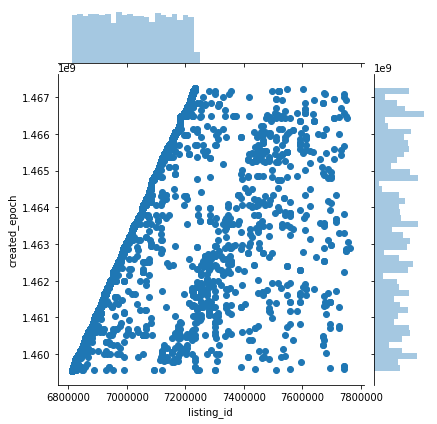

In [23]:
sns.jointplot('listing_id', 'created_epoch', full_data)

In [24]:
min_listing_id = full_data['listing_id'].min()
max_listing_id = full_data['listing_id'].max()
full_data['norm_listing_id']=full_data['listing_id'].apply(lambda x:np.float64((x-min_listing_id+1))/(max_listing_id-min_listing_id+1))
listing_vars = [ 'norm_listing_id']

In [25]:
full_num_vars = num_vars + date_num_vars + additional_num_vars + interactive_num_vars+ geo_cat_vars +geo_num_vars + count_vars \
     + listing_vars
full_cat_vars = LE_vars + mean_coded_vars
full_vars = full_num_vars + full_cat_vars
train_x = sparse.hstack([full_data[full_vars], 
                         feature_sparse, 
                         desc_sparse, 
                         st_addr_sparse]).tocsr()[:train_size]
train_y = full_data['target'][:train_size].values
test_x = sparse.hstack([full_data[full_vars], 
                        feature_sparse, 
                        desc_sparse, 
                        st_addr_sparse]).tocsr()[train_size:]
test_y = full_data['target'][train_size:].values


full_vars = full_vars + feature_vars + desc_vars + st_addr_vars    
print ("training data size: ", train_x.shape,"testing data size: ", test_x.shape)

training data size:  (49352, 381) testing data size:  (74659, 381)


In [26]:
%%time
lgb_params = dict()
lgb_params['objective'] = 'multiclass'
lgb_params['num_class'] = 3
lgb_params['learning_rate'] = 0.1
lgb_params['num_leaves'] = 63
lgb_params['max_depth'] = 15
lgb_params['min_gain_to_split '] = 1
lgb_params['subsample'] = 0.7
lgb_params['colsample_bytree'] = 0.7
lgb_params['min_sum_hessian_in_leaf'] = 0.001
lgb_params['seed']=42

lgb_cv = lgb.cv(lgb_params,
                lgb.Dataset(train_x,
                            label=train_y
                            ),
                num_boost_round=100000,
                nfold=5,
                stratified=True,
                shuffle=True,
                early_stopping_rounds=50,
                seed=42,
                verbose_eval=50)


best_score = min(lgb_cv['multi_logloss-mean'])
best_iteration = len(lgb_cv['multi_logloss-mean'])
print ('Best iteration: %d, best score: %f' % (best_iteration, best_score))


[50]	cv_agg's multi_logloss: 0.545356 + 0.00461699
[100]	cv_agg's multi_logloss: 0.533574 + 0.00493584
[150]	cv_agg's multi_logloss: 0.532052 + 0.0048654
Best iteration: 136, best score: 0.531804
CPU times: user 5min 28s, sys: 1.98 s, total: 5min 30s
Wall time: 1min 24s


In [27]:
%%time
lgb_params = dict()
lgb_params['objective'] = 'multiclass'
lgb_params['num_class'] = 3
lgb_params['learning_rate'] = 0.05
lgb_params['num_leaves'] = 63
lgb_params['max_depth'] = 15
lgb_params['min_gain_to_split '] = 1
lgb_params['subsample'] = 0.7
lgb_params['colsample_bytree'] = 0.7
lgb_params['min_sum_hessian_in_leaf'] = 0.001
lgb_params['seed']=42

lgb_cv = lgb.cv(lgb_params,
                lgb.Dataset(train_x,
                            label=train_y
                            ),
                num_boost_round=100000,
                nfold=5,
                stratified=True,
                shuffle=True,
                early_stopping_rounds=50,
                seed=42,
                verbose_eval=50)


best_score = min(lgb_cv['multi_logloss-mean'])
best_iteration = len(lgb_cv['multi_logloss-mean'])
print ('Best iteration: %d, best score: %f' % (best_iteration, best_score))

[50]	cv_agg's multi_logloss: 0.573278 + 0.00354571
[100]	cv_agg's multi_logloss: 0.544414 + 0.00501547
[150]	cv_agg's multi_logloss: 0.535681 + 0.00530418
[200]	cv_agg's multi_logloss: 0.532186 + 0.00529804
[250]	cv_agg's multi_logloss: 0.53069 + 0.00523651
[300]	cv_agg's multi_logloss: 0.530067 + 0.00522046
[350]	cv_agg's multi_logloss: 0.529986 + 0.00512631
Best iteration: 344, best score: 0.529960
CPU times: user 11min 33s, sys: 4.17 s, total: 11min 38s
Wall time: 2min 57s


## Price

In [28]:
mkt_price = full_data.groupby(['building_id', 'display_address', 'bedrooms', 'bathrooms']).price.mean().reset_index()
mkt_price = pd.merge(full_data[['building_id', 'display_address', 'bedrooms', 'bathrooms']],
                     mkt_price, how='left', on=['building_id', 'display_address', 'bedrooms', 'bathrooms']).price
full_data['mkt_price'] = mkt_price.values
full_data['diff_to_mkt_price'] = full_data['price'] - full_data['mkt_price']
full_data['ratio_to_mkt_price'] = full_data['price'] / full_data['mkt_price']

price_vars = ['diff_to_mkt_price', 'ratio_to_mkt_price']

## Hack "HopScore"

Though it may not be 100% correlated it turns out that Renthop uses a system called ["**HopScore**"](https://www.renthop.com/agent-guide/the-hopscore) to rank listings. According to the official instruction there are three things to consider to improve HopScore:

* Listing freshness
* Listing quality
* Manager performance

This finding is a breakthrough when I worked on feature engineering for this competition and resulted quite a few fruitful ideas.


### Listing freshness and listing quality

In [29]:
import hashlib

# unique identifer for listings - photo links uniquely identify a listing
full_data['photos_str'] = full_data['photos'].astype(str)
full_data['listing_uid'] = full_data[['manager_id', 'building_id','photos_str']].apply(lambda x: hashlib.md5((x[0] + x[1] + x[2]).encode()).hexdigest(), axis=1 )
full_data['posted_times'] = full_data.groupby('listing_uid').created_datetime.rank(method='first', na_option='top',pct=True)

# Using html tag may improve listing quality
full_data['num_of_html_tag']=full_data.description.apply(lambda x:x.count('<'))

# Studies have shown that titles with excessive all caps and special characters give renters the impression 
# that the listing is fraudulent – i.e. BEAUTIFUL***APARTMENT***CHELSEA.
full_data['num_of_#']=full_data.description.apply(lambda x:x.count('#'))
full_data['num_of_!']=full_data.description.apply(lambda x:x.count('!'))
full_data['num_of_$']=full_data.description.apply(lambda x:x.count('$'))
full_data['num_of_*']=full_data.description.apply(lambda x:x.count('*'))
full_data['num_of_>']=full_data.description.apply(lambda x:x.count('>'))
full_data['num_of_puncs']=full_data['num_of_#'] + full_data['num_of_!'] + full_data['num_of_$'] + full_data['num_of_*'] + full_data['num_of_>']
full_data['puncs_ratio'] = full_data['num_of_puncs']/full_data['len_of_desc']
full_data['upper_char_ratio'] = full_data['description'].apply(lambda x: 0 if sum([s.isalpha() for s in x])==0 else sum([s.isalpha()&s.isupper() for s in x])/ sum([s.isalpha() for s in x]))

# Accuracy of location/ address
full_data['disp_is_street'] = (full_data['display_address'] == full_data['street_address'])*1
full_data['disp_st_addr_word_ratio'] = full_data.apply(lambda x:len(x['display_address'].split(' '))/len(x['street_address'].split(' ')), axis=1)

listing_quality_vars = ['disp_is_street', 'num_of_html_tag','num_of_#','num_of_!','num_of_$', 'num_of_*',
                        'posted_times', 'disp_st_addr_word_ratio','upper_char_ratio']

In [30]:
full_num_vars = num_vars + date_num_vars + additional_num_vars + interactive_num_vars+ geo_cat_vars +geo_num_vars + count_vars \
    + listing_vars + listing_quality_vars
full_cat_vars = LE_vars + mean_coded_vars
full_vars = full_num_vars + full_cat_vars
train_x = sparse.hstack([full_data[full_vars], 
                         feature_sparse, 
                         desc_sparse, 
                         st_addr_sparse]).tocsr()[:train_size]
train_y = full_data['target'][:train_size].values
test_x = sparse.hstack([full_data[full_vars], 
                        feature_sparse, 
                        desc_sparse, 
                        st_addr_sparse]).tocsr()[train_size:]
test_y = full_data['target'][train_size:].values


full_vars = full_vars + feature_vars + desc_vars + st_addr_vars    
print ("training data size: ", train_x.shape,"testing data size: ", test_x.shape)

training data size:  (49352, 390) testing data size:  (74659, 390)


In [31]:
%%time
lgb_params = dict()
lgb_params['objective'] = 'multiclass'
lgb_params['num_class'] = 3
lgb_params['learning_rate'] = 0.05
lgb_params['num_leaves'] = 63
lgb_params['max_depth'] = 15
lgb_params['min_gain_to_split '] = 1
lgb_params['subsample'] = 0.7
lgb_params['colsample_bytree'] = 0.7
lgb_params['min_sum_hessian_in_leaf'] = 0.001
lgb_params['seed']=42

lgb_cv = lgb.cv(lgb_params,
                lgb.Dataset(train_x,
                            label=train_y
                            ),
                num_boost_round=100000,
                nfold=5,
                stratified=True,
                shuffle=True,
                early_stopping_rounds=50,
                seed=42,
                verbose_eval=50)


best_score = min(lgb_cv['multi_logloss-mean'])
best_iteration = len(lgb_cv['multi_logloss-mean'])
print ('Best iteration: %d, best score: %f' % (best_iteration, best_score))

# 0.547453

[50]	cv_agg's multi_logloss: 0.573034 + 0.00368081
[100]	cv_agg's multi_logloss: 0.544559 + 0.00456516
[150]	cv_agg's multi_logloss: 0.53591 + 0.00466528
[200]	cv_agg's multi_logloss: 0.532557 + 0.00456405
[250]	cv_agg's multi_logloss: 0.531003 + 0.00458374
[300]	cv_agg's multi_logloss: 0.530577 + 0.00471197
Best iteration: 289, best score: 0.530488
CPU times: user 10min 31s, sys: 3.72 s, total: 10min 34s
Wall time: 2min 41s


### Manager performance

In [32]:
from scipy.stats import skew, kurtosis

def p25(x):
    return np.percentile(x, 25)
def p50(x):
    return np.percentile(x, 50)
def p75(x):
    return np.percentile(x, 75)
def nunique(x):
    return np.size(np.unique(x))
def max_min(x):
    return np.max(x)-np.min(x)
def p75_p25(x):
    return np.percentile(x, 75)-np.percentile(x, 25)



def get_group_stats(df, stat_funcs, target_column, group_column, ranking=False, ranking_pct=True):
    aggr = df.groupby(group_column)[target_column].agg([v for v in stat_funcs.values()]).reset_index()
    aggr.columns = [group_column] + [  target_column + '_' + k + '_by_' + group_column for k in stat_funcs.keys()]
    aggr = df[[group_column]].merge(aggr, how='left', on=group_column)
    
    #rank
    if ranking:
        aggr[target_column + '_rank_by_' + group_column] = df.groupby(group_column)[target_column].rank(method='dense', 
                                                                                                    na_option='top',
                                                                                                    pct=ranking_pct)
    return aggr.drop(group_column, axis=1)

In [33]:
stat_funcs = {
#     'count_unique': nunique,
    'mean': np.mean,
    'min': np.min,
    'max': np.max,
    'std': np.std,
    'p25': p25,
    'p50': p50,
    'p75': p75,
    'skew': skew,
    'kurtosis': kurtosis,
    'max_min': max_min,
    'p75_p25': p75_p25
}


mgr_aggr = pd.DataFrame()
for num_var in num_vars + additional_num_vars + listing_quality_vars:
    mgr_aggr = pd.concat([mgr_aggr,
                          get_group_stats(full_data, stat_funcs,
                                          target_column=num_var, group_column='manager_id', ranking=False)
                          ],
                         axis=1
                         )
    
## manager activeness
mgr_aggr = pd.concat([mgr_aggr,
                      get_group_stats(full_data, {'max_min': max_min, 'p75_p25': p75_p25},
                                      target_column='created_epoch', group_column='manager_id', ranking=False)
                      ],
                     axis=1
                     )

mgr_aggr = pd.concat([mgr_aggr,
                      get_group_stats(full_data, {'nunique': nunique},
                                      target_column='created_dayofyear', group_column='manager_id', ranking=False)
                      ],
                     axis=1
                     )

## Buildings managed by the manager
mgr_aggr = pd.concat([mgr_aggr,
                      get_group_stats(full_data, {'nunique': nunique},
                                      target_column='building_id', group_column='manager_id', ranking=False)
                      ],
                     axis=1
                     )

## Areas 
for aggr_col in ['geo_area_50', 'geo_area_100', 'geo_area_200']:
    mgr_aggr = pd.concat([mgr_aggr,
                          get_group_stats(full_data, {'nunique': nunique},
                                          target_column=aggr_col, group_column='manager_id', ranking=False)
                          ],
                         axis=1
                         )

## Price fairness    
for aggr_col in ['diff_to_mkt_price', 'ratio_to_mkt_price']:
    mgr_aggr = pd.concat([mgr_aggr,
                          get_group_stats(full_data, {'mean': np.mean},
                                          target_column=aggr_col, group_column='manager_id', ranking=False)
                          ],
                         axis=1
                         )

In [34]:
full_num_vars = num_vars + date_num_vars + additional_num_vars + interactive_num_vars+ geo_cat_vars + count_vars \
    + listing_vars + listing_quality_vars
full_cat_vars = LE_vars + mean_coded_vars
full_vars = full_num_vars + full_cat_vars
train_x = sparse.hstack([full_data[full_vars],
                         feature_sparse,
                         desc_sparse,
                         st_addr_sparse,
                         mgr_aggr]).tocsr()[:train_size]
train_y = full_data['target'][:train_size].values
test_x = sparse.hstack([full_data[full_vars],
                        feature_sparse,
                        desc_sparse,
                        st_addr_sparse,
                        mgr_aggr]).tocsr()[train_size:]
test_y = full_data['target'][train_size:].values


full_vars = full_vars + feature_vars + desc_vars + st_addr_vars
print("training data size: ", train_x.shape,
      "testing data size: ", test_x.shape)

training data size:  (49352, 639) testing data size:  (74659, 639)


In [35]:
%%time
lgb_params = dict()
lgb_params['objective'] = 'multiclass'
lgb_params['num_class'] = 3
lgb_params['learning_rate'] = 0.05
lgb_params['num_leaves'] = 63
lgb_params['max_depth'] = 15
lgb_params['min_gain_to_split '] = 1
lgb_params['subsample'] = 0.7
lgb_params['colsample_bytree'] = 0.7
lgb_params['min_sum_hessian_in_leaf'] = 0.001
lgb_params['seed']=42

lgb_cv = lgb.cv(lgb_params,
                lgb.Dataset(train_x,
                            label=train_y
                            ),
                num_boost_round=100000,
                nfold=5,
                stratified=True,
                shuffle=True,
                early_stopping_rounds=50,
                seed=42,
                verbose_eval=50)


best_score = min(lgb_cv['multi_logloss-mean'])
best_iteration = len(lgb_cv['multi_logloss-mean'])
print ('Best iteration: %d, best score: %f' % (best_iteration, best_score))
# Best iteration: 306, best score: 0.531753

[50]	cv_agg's multi_logloss: 0.572387 + 0.00324105
[100]	cv_agg's multi_logloss: 0.543591 + 0.00447352
[150]	cv_agg's multi_logloss: 0.53509 + 0.00463003
[200]	cv_agg's multi_logloss: 0.531591 + 0.00472818
[250]	cv_agg's multi_logloss: 0.529993 + 0.00471097
[300]	cv_agg's multi_logloss: 0.529779 + 0.00478228
Best iteration: 288, best score: 0.529715
CPU times: user 24min 36s, sys: 5.57 s, total: 24min 41s
Wall time: 6min 17s


### Similar for building

In [36]:
stat_funcs = {
#     'count_unique': nunique,
    'mean': np.mean,
    'min': np.min,
    'max': np.max,
    'std': np.std,
    'p25': p25,
    'p50': p50,
    'p75': p75,
    'skew': skew,
    'kurtosis': kurtosis,
    'max_min': max_min,
    'p75_p25': p75_p25
}


building_aggr = pd.DataFrame()

building_aggr = pd.concat([building_aggr,
                      get_group_stats(full_data, stat_funcs,
                                      target_column='price', group_column='building_id', ranking=False)
                      ],
                     axis=1
                     )
    

## Buildings managed by the manager
building_aggr = pd.concat([building_aggr,
                      get_group_stats(full_data, {'nunique': nunique},
                                      target_column='manager_id', group_column='building_id', ranking=False)
                      ],
                     axis=1
                     )

In [37]:
full_num_vars = num_vars + date_num_vars + additional_num_vars + interactive_num_vars+ geo_cat_vars +geo_num_vars + count_vars \
    + listing_vars + listing_quality_vars
full_cat_vars = LE_vars + mean_coded_vars
full_vars = full_num_vars + full_cat_vars
train_x = sparse.hstack([full_data[full_vars],
                         feature_sparse,
                         desc_sparse,
                         st_addr_sparse,
                         mgr_aggr,
                         building_aggr]).tocsr()[:train_size]
train_y = full_data['target'][:train_size].values
test_x = sparse.hstack([full_data[full_vars],
                        feature_sparse,
                        desc_sparse,
                        st_addr_sparse,
                        mgr_aggr,
                       building_aggr]).tocsr()[train_size:]
test_y = full_data['target'][train_size:].values


full_vars = full_vars + feature_vars + desc_vars + st_addr_vars
print("training data size: ", train_x.shape,
      "testing data size: ", test_x.shape)

training data size:  (49352, 653) testing data size:  (74659, 653)


In [38]:
%%time
lgb_params = dict()
lgb_params['objective'] = 'multiclass'
lgb_params['num_class'] = 3
lgb_params['learning_rate'] = 0.05
lgb_params['num_leaves'] = 63
lgb_params['max_depth'] = 15
lgb_params['min_gain_to_split '] = 1
lgb_params['subsample'] = 0.7
lgb_params['colsample_bytree'] = 0.7
lgb_params['min_sum_hessian_in_leaf'] = 0.001
lgb_params['seed']=42

lgb_cv = lgb.cv(lgb_params,
                lgb.Dataset(train_x,
                            label=train_y
                            ),
                num_boost_round=100000,
                nfold=5,
                stratified=True,
                shuffle=True,
                early_stopping_rounds=50,
                seed=42,
                verbose_eval=50)


best_score = min(lgb_cv['multi_logloss-mean'])
best_iteration = len(lgb_cv['multi_logloss-mean'])
print ('Best iteration: %d, best score: %f' % (best_iteration, best_score))
# Best iteration: 306, best score: 0.531753

[50]	cv_agg's multi_logloss: 0.571973 + 0.00341128
[100]	cv_agg's multi_logloss: 0.54311 + 0.00421872
[150]	cv_agg's multi_logloss: 0.534122 + 0.0047964
[200]	cv_agg's multi_logloss: 0.530522 + 0.00488872
[250]	cv_agg's multi_logloss: 0.529113 + 0.00483096
[300]	cv_agg's multi_logloss: 0.52891 + 0.0051341
Best iteration: 291, best score: 0.528779
CPU times: user 27min 2s, sys: 5.76 s, total: 27min 8s
Wall time: 6min 54s


## Location Location Location!!!

Not all listings were created equally. Location is one of the most dominant factors when seeking a place to live. When we think of location we are not only talking about the absolute location but the relative location, e.g. proximity to facilities such as school, transportations and supermarkets. Unfortunately, these information are not provided by the dataset naively but thanks to Kaggler [Farron](https://www.kaggle.com/mmueller) who graciously shared his secret sauce which brilliantly hacked the proximity information and helped him win the second place in this competition. Here's what he did: 
> It consists of kmeans cluster of (latitude, longitude) followed by computing statistics like the ones above and cluster center distances. In order to get some proxies for PoI's in the neighborhood, I created clusters after filtering the dataset based on certain words in the descriptions. That way, I estimated coordinates for things like "supermarket", "shopping", "subway", "bus", "health", "fitness", "park" etc. Afterwards I created minimal distances to those locations as well as counts based on different distances cut-offs.


### Parks

The biggest challenge for replicating Faron's great idea is to figure out the appropriate number of clusters for each category. How can we do that?

In [39]:
from geopy.distance import vincenty

from sklearn.cluster import KMeans
park_listings = full_data[full_data[['description', 'features']].apply(lambda x: 'park' in x[0] or 'park' in x[1], axis=1)][['latitude', 'longitude']]

park_n_clusters = 25
kms = KMeans(n_clusters=park_n_clusters)
kms.fit(park_listings)

park_dist_data = pd.DataFrame(kms.transform(full_data[['latitude', 'longitude']]),
                              columns = ['dist_to_park_' + str(i) for i in range(park_n_clusters)]
                             )

In [40]:
full_num_vars = num_vars + date_num_vars + additional_num_vars + interactive_num_vars +geo_num_vars+ geo_cat_vars + count_vars \
    + listing_vars + listing_quality_vars  
full_cat_vars = LE_vars + mean_coded_vars
full_vars = full_num_vars + full_cat_vars
train_x = sparse.hstack([full_data[full_vars],
                         feature_sparse,
                         desc_sparse,
                         st_addr_sparse,
                         mgr_aggr,
                        building_aggr,
                        park_dist_data]).tocsr()[:train_size]
train_y = full_data['target'][:train_size].values
test_x = sparse.hstack([full_data[full_vars],
                        feature_sparse,
                        desc_sparse,
                        st_addr_sparse,
                        mgr_aggr,
                       building_aggr,
                       park_dist_data]).tocsr()[train_size:]
test_y = full_data['target'][train_size:].values


full_vars = full_vars + feature_vars + desc_vars + st_addr_vars
print("training data size: ", train_x.shape,
      "testing data size: ", test_x.shape)

training data size:  (49352, 678) testing data size:  (74659, 678)


In [41]:
%%time
lgb_params = dict()
lgb_params['objective'] = 'multiclass'
lgb_params['num_class'] = 3
lgb_params['learning_rate'] = 0.05
lgb_params['num_leaves'] = 63
lgb_params['max_depth'] = 15
lgb_params['min_gain_to_split '] = 1
lgb_params['subsample'] = 0.7
lgb_params['colsample_bytree'] = 0.7
lgb_params['min_sum_hessian_in_leaf'] = 0.001
lgb_params['seed']=42

lgb_cv = lgb.cv(lgb_params,
                lgb.Dataset(train_x,
                            label=train_y
                            ),
                num_boost_round=100000,
                nfold=5,
                stratified=True,
                shuffle=True,
                early_stopping_rounds=50,
                seed=42,
                verbose_eval=50)


best_score = min(lgb_cv['multi_logloss-mean'])
best_iteration = len(lgb_cv['multi_logloss-mean'])
print ('Best iteration: %d, best score: %f' % (best_iteration, best_score))

[50]	cv_agg's multi_logloss: 0.569651 + 0.0032432
[100]	cv_agg's multi_logloss: 0.539857 + 0.00456987
[150]	cv_agg's multi_logloss: 0.531129 + 0.00481811
[200]	cv_agg's multi_logloss: 0.527458 + 0.00483663
[250]	cv_agg's multi_logloss: 0.526404 + 0.00466007
[300]	cv_agg's multi_logloss: 0.525873 + 0.00471233
Best iteration: 299, best score: 0.525851
CPU times: user 30min 16s, sys: 6.14 s, total: 30min 22s
Wall time: 7min 43s


For your reference, we can use the following snippet to fine tune the optimal number clusters

```python

scores = []
for park_n_clusters in (10, 15, 20, 25, 30):
    kms = KMeans(n_clusters=park_n_clusters)
    kms.fit(park_listings)

    park_dist_data = pd.DataFrame(kms.transform(full_data[['latitude', 'longitude']]),
                                  columns=['dist_to_park_' +
                                      str(i) for i in range(park_n_clusters)]
                                 )

    full_num_vars = num_vars + date_num_vars + additional_num_vars + \
        interactive_num_vars + listing_vars + listing_quality_vars + magic_vars + \
        num_cat_vars + mean_coded_vars + distance_vars
    full_cat_vars = LE_vars
    full_vars = full_num_vars + full_cat_vars
    train_x = sparse.hstack([full_data[full_vars],
                             feature_sparse,
                             desc_sparse,
                             st_addr_sparse,
                             mgr_aggr,
                            park_dist_data]).tocsr()[:train_size]
    train_y = full_data['target'][:train_size].values
    test_x = sparse.hstack([full_data[full_vars],
                            feature_sparse,
                            desc_sparse,
                            st_addr_sparse,
                            mgr_aggr,
                            park_dist_data]).tocsr()[train_size:]
    test_y = full_data['target'][train_size:].values

    full_vars = full_vars + feature_vars + desc_vars + st_addr_vars
    print("training data size: ", train_x.shape,
          "testing data size: ", test_x.shape)

    lgb_params = dict()
    lgb_params['objective'] = 'multiclass'
    lgb_params['num_class'] = 3
    lgb_params['learning_rate'] = 0.05
    lgb_params['num_leaves'] = 63
    lgb_params['max_depth'] = 15
    lgb_params['min_gain_to_split '] = 1
    lgb_params['subsample'] = 0.7
    lgb_params['colsample_bytree'] = 0.7
    lgb_params['min_sum_hessian_in_leaf'] = 0.001
    lgb_params['seed'] = 42

    lgb_cv = lgb.cv(lgb_params,
                    lgb.Dataset(train_x,
                                label=train_y
                                ),
                    num_boost_round=100000,
                    nfold=5,
                    stratified=True,
                    shuffle=True,
                    early_stopping_rounds=50,
                    seed=42,
                    verbose_eval=100)

    best_score = min(lgb_cv['multi_logloss-mean'])
    best_iteration = len(lgb_cv['multi_logloss-mean'])
    print('Best iteration: %d, best score: %f' % (best_iteration, best_score))
    scores.append([park_n_clusters, best_score])
scores = np.array(scores)
best_park_n_clusters = scores[:, 0][(np.argmin(scores[:, 1]))]
print('best number of clusters: %d, best score: %f' % (best_park_n_clusters, np.min(scores[:, 1])))


```

### Subways

In [42]:
subway_listings = full_data[full_data[['description', 'features']].apply(lambda x: 'subway' in x[0] or 'subway' in x[1], axis=1)][['latitude', 'longitude']]

subway_n_clusters = 400
kms = KMeans(n_clusters=subway_n_clusters)
kms.fit(subway_listings)

subway_dist_data = pd.DataFrame(kms.transform(full_data[['latitude', 'longitude']]),
                              columns = ['dist_to_subway_' + str(i) for i in range(subway_n_clusters)]
                             )

In [43]:
full_num_vars = num_vars + date_num_vars + additional_num_vars + interactive_num_vars+geo_num_vars+ geo_cat_vars + count_vars \
    + listing_vars + listing_quality_vars 
full_cat_vars = LE_vars + mean_coded_vars
full_vars = full_num_vars + full_cat_vars
train_x = sparse.hstack([full_data[full_vars],
                         feature_sparse,
                         desc_sparse,
                         st_addr_sparse,
                         mgr_aggr,
                        building_aggr,
                        park_dist_data,
                        subway_dist_data]).tocsr()[:train_size]
train_y = full_data['target'][:train_size].values
test_x = sparse.hstack([full_data[full_vars],
                        feature_sparse,
                        desc_sparse,
                        st_addr_sparse,
                        mgr_aggr,
                       building_aggr,
                       park_dist_data,
                       subway_dist_data]).tocsr()[train_size:]
test_y = full_data['target'][train_size:].values


full_vars = full_vars + feature_vars + desc_vars + st_addr_vars
print("training data size: ", train_x.shape,
      "testing data size: ", test_x.shape)

training data size:  (49352, 1078) testing data size:  (74659, 1078)


In [44]:
%%time
lgb_params = dict()
lgb_params['objective'] = 'multiclass'
lgb_params['num_class'] = 3
lgb_params['learning_rate'] = 0.05
lgb_params['num_leaves'] = 63
lgb_params['max_depth'] = 15
lgb_params['min_gain_to_split '] = 1
lgb_params['subsample'] = 0.7
lgb_params['colsample_bytree'] = 0.7
lgb_params['min_sum_hessian_in_leaf'] = 0.001
lgb_params['seed']=42

lgb_cv = lgb.cv(lgb_params,
                lgb.Dataset(train_x,
                            label=train_y
                            ),
                num_boost_round=100000,
                nfold=5,
                stratified=True,
                shuffle=True,
                early_stopping_rounds=50,
                seed=42,
                verbose_eval=50)


best_score = min(lgb_cv['multi_logloss-mean'])
best_iteration = len(lgb_cv['multi_logloss-mean'])
print ('Best iteration: %d, best score: %f' % (best_iteration, best_score))

[50]	cv_agg's multi_logloss: 0.569265 + 0.00342119
[100]	cv_agg's multi_logloss: 0.539553 + 0.00422727
[150]	cv_agg's multi_logloss: 0.530582 + 0.00450288
[200]	cv_agg's multi_logloss: 0.527164 + 0.00480983
[250]	cv_agg's multi_logloss: 0.526031 + 0.00481716
[300]	cv_agg's multi_logloss: 0.525936 + 0.00473577
Best iteration: 288, best score: 0.525873
CPU times: user 57min 23s, sys: 7.78 s, total: 57min 31s
Wall time: 14min 39s


## item2vec

We can use the same idea for word2vec to embed any items

In [45]:
import spacy ## Spacy is the de-facto NLP tool used by industry
from gensim.models import FastText  
nlp = spacy.load("en_core_web_sm")

## Tokenize a sentence
def seq_to_token(seq, nlp=nlp):
    doc = nlp(str(seq).lower())
    tokens = [token.text for token in doc if not ( token.is_space | token.is_stop|token.like_num)]
    return tokens

## Convert tokens to vector
def tokens_to_vec(tokens, model, vec_size=10):
    if len(tokens)==0:
        return np.zeors(vec_size)
    else:
        return np.array([emb_model[token] for token in tokens]).mean(axis=1)

### Embed building id

In [46]:
## Step 1: Generate "sentences"
building_by_mgr = full_data.groupby('manager_id')['building_id'].apply(list)
building_by_mgr.head()

manager_id
0000abd7518b94c35a90d64b56fbf3e6    [d64120032c7c77ed2d3caf743b33201b, b491b11c7ea...
001ce808ce1720e24a9510e014c69707    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
003fc4e9a70053082f131b1054966aaf                                         [0, 0, 0, 0]
00607a02f6efd9c6c7c588826e471ee9    [bbd82dada059fe400bd515589333bae9, 8e9dc82b439...
00995ff28d79127ed2dca8320e9e7d09    [77fccbedf29d0035ea311701fd715823, ad67f6181a4...
Name: building_id, dtype: object

In [47]:
## Step 2: Train a fasttext model
building_model = FastText(size=10, window=3, min_count=1, workers=16)  # instantiate
building_model.build_vocab(sentences=building_by_mgr)
building_model.train(sentences=building_by_mgr.values, total_examples=len(building_by_mgr.values), epochs=5)

## Take a look at the embedding for building_id 8a8b08e08888819a3e745005a8cd0408
building_model['8a8b08e08888819a3e745005a8cd0408']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


array([ 0.7843275 , -1.0873846 ,  1.5095539 , -0.11258737,  0.16320401,
        0.32354936,  2.1196125 ,  1.2524652 ,  0.8789119 , -0.78124624],
      dtype=float32)

In [48]:
## Step 3: Embed building ids
building_emb = full_data['building_id'].apply(lambda x:building_model[x]).values
building_emb = np.array([e.reshape(1,-1) for e in building_emb]).reshape(-1,10)
building_emb

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([[  0.86782306,  -1.1663593 ,   1.5430108 , ...,   1.3460227 ,
          0.8868551 ,  -0.77050924],
       [  0.5621958 ,  -1.432132  ,   1.7951    , ...,   1.7809668 ,
          1.3062751 ,  -1.0434483 ],
       [  0.5775995 ,  -1.5462695 ,   2.0648592 , ...,   1.9381046 ,
          1.4727904 ,  -1.2262148 ],
       ...,
       [ 18.210459  , -16.519539  ,   4.8748493 , ...,  17.479746  ,
         -1.0313543 ,   3.023367  ],
       [  1.0618416 ,  -1.1884751 ,   1.8580693 , ...,   1.3193855 ,
          0.9811291 ,  -0.9330204 ],
       [  1.3361573 ,  -1.7097892 ,   1.9929698 , ...,   1.9206597 ,
          1.1060035 ,  -0.9139155 ]], dtype=float32)

## Embed manager id

In [49]:
manager_by_building = full_data.groupby('building_id')['manager_id'].apply(list)  
manager_model = FastText(size=10, window=3, min_count=1, workers=16)
manager_model.build_vocab(sentences=manager_by_building)
manager_model.train(sentences=manager_by_building.values, 
                    total_examples=len(manager_by_building.values), epochs=5)
manager_emb = full_data['manager_id'].apply(lambda x:manager_model[x]).values
manager_emb = np.array([e.reshape(1,-1) for e in manager_emb]).reshape(-1,10)
manager_emb

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([[ 0.5459034 , -2.4338746 , -1.7066944 , ...,  1.869851  ,
        -4.170246  , -0.44711676],
       [-1.4953406 , -2.119001  , -0.2823045 , ...,  0.35475844,
         0.11215224,  0.21007243],
       [-3.6713762 , -2.7806685 , -0.3667828 , ...,  1.0348134 ,
         1.0134226 ,  0.61292624],
       ...,
       [-1.6645426 , -2.3138847 , -1.2993264 , ...,  0.1948381 ,
        -0.13117908,  0.1935277 ],
       [-2.1199002 , -4.4403143 , -0.19360483, ...,  0.4009747 ,
         0.60684615, -0.8989814 ],
       [-1.173622  , -0.34279838,  0.13306461, ...,  0.21445557,
         0.22133149,  1.1361825 ]], dtype=float32)

In [50]:
manager_by_building = full_data.groupby('building_id')['manager_id'].apply(list)  
manager_model = FastText(size=10, window=3, min_count=1, workers=16)
manager_model.build_vocab(sentences=manager_by_building)
manager_model.train(sentences=manager_by_building.values, 
                    total_examples=len(manager_by_building.values), epochs=5)
manager_emb = full_data['manager_id'].apply(lambda x:manager_model[x]).values
manager_emb = np.array([e.reshape(1,-1) for e in manager_emb]).reshape(-1,10)
manager_emb

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([[ 0.02809998, -2.0764682 , -1.8587314 , ...,  0.74020034,
        -4.07501   , -1.1552163 ],
       [-1.5539856 , -2.0964093 , -0.3568625 , ...,  0.29643664,
         0.25107074,  0.03389387],
       [-3.6056962 , -2.7186322 , -0.22760876, ...,  0.7978077 ,
         1.1487135 ,  0.24353907],
       ...,
       [-1.9285547 , -2.365765  , -1.4261793 , ...,  0.18406631,
        -0.11812768,  0.24255364],
       [-2.193354  , -4.4679985 , -0.34445256, ...,  0.35324544,
         0.82622594, -0.9537938 ],
       [-0.9998246 , -0.48436055,  0.30979523, ...,  0.22766794,
         0.41234887,  0.91283065]], dtype=float32)

In [51]:
full_num_vars = num_vars + date_num_vars + additional_num_vars + interactive_num_vars+geo_num_vars+ geo_cat_vars + count_vars \
    + listing_vars + listing_quality_vars  
full_cat_vars = LE_vars + mean_coded_vars
full_vars = full_num_vars + full_cat_vars
train_x = sparse.hstack([full_data[full_vars],
                         feature_sparse,
                         desc_sparse,
                         st_addr_sparse,
                         mgr_aggr,
                        building_aggr,
                        park_dist_data,
                        subway_dist_data,
                        manager_emb,
                        building_emb]).tocsr()[:train_size]
train_y = full_data['target'][:train_size].values
test_x = sparse.hstack([full_data[full_vars],
                        feature_sparse,
                        desc_sparse,
                        st_addr_sparse,
                        mgr_aggr,
                       building_aggr,
                       park_dist_data,
                       subway_dist_data,
                       manager_emb,
                    building_emb]).tocsr()[train_size:]
test_y = full_data['target'][train_size:].values



print("training data size: ", train_x.shape,
      "testing data size: ", test_x.shape)

training data size:  (49352, 1098) testing data size:  (74659, 1098)


In [52]:
%%time
lgb_params = dict()
lgb_params['objective'] = 'multiclass'
lgb_params['num_class'] = 3
lgb_params['learning_rate'] = 0.05
lgb_params['num_leaves'] = 63
lgb_params['max_depth'] = 15
lgb_params['min_gain_to_split '] = 1
lgb_params['subsample'] = 0.7
lgb_params['colsample_bytree'] = 0.7
lgb_params['min_sum_hessian_in_leaf'] = 0.001
lgb_params['seed']=42

lgb_cv = lgb.cv(lgb_params,
                lgb.Dataset(train_x,
                            label=train_y
                            ),
                num_boost_round=100000,
                nfold=5,
                stratified=True,
                shuffle=True,
                early_stopping_rounds=50,
                seed=42,
                verbose_eval=50)


best_score = min(lgb_cv['multi_logloss-mean'])
best_iteration = len(lgb_cv['multi_logloss-mean'])
print ('Best iteration: %d, best score: %f' % (best_iteration, best_score))

[50]	cv_agg's multi_logloss: 0.568772 + 0.00378623
[100]	cv_agg's multi_logloss: 0.538713 + 0.00493945
[150]	cv_agg's multi_logloss: 0.53024 + 0.0056358
[200]	cv_agg's multi_logloss: 0.526608 + 0.00564483
[250]	cv_agg's multi_logloss: 0.525218 + 0.00563892
[300]	cv_agg's multi_logloss: 0.525288 + 0.00579725
Best iteration: 260, best score: 0.525112
CPU times: user 35min 37s, sys: 4.93 s, total: 35min 42s
Wall time: 17min 52s


## The magic feature

Firstly mentioned by Grand Master Silogram
https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/discussion/31765

Discovered and made available to public by another Grand Master KazAnova
https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/discussion/31870

It may contain the information when the listing was actually created.

In [53]:
image_date = pd.read_csv("../input/twosigma-magic-feature/listing_image_time.csv")

image_date.columns = ["listing_id", "image_time_stamp"]
full_data = pd.merge(full_data, image_date, on="listing_id", how="left")
magic_vars = ['image_time_stamp']

In [54]:
full_num_vars = num_vars + date_num_vars + additional_num_vars + interactive_num_vars+geo_num_vars+ geo_cat_vars + count_vars \
    + listing_vars + listing_quality_vars + magic_vars + price_vars
full_cat_vars = LE_vars + mean_coded_vars
full_vars = full_num_vars + full_cat_vars
train_x = sparse.hstack([full_data[full_vars],
                         feature_sparse,
                         desc_sparse,
                         st_addr_sparse,
                         mgr_aggr,
                        building_aggr,
                        park_dist_data,
                        subway_dist_data,
                        manager_emb,
                        building_emb]).tocsr()[:train_size]
train_y = full_data['target'][:train_size].values
test_x = sparse.hstack([full_data[full_vars],
                        feature_sparse,
                        desc_sparse,
                        st_addr_sparse,
                        mgr_aggr,
                       building_aggr,
                       park_dist_data,
                       subway_dist_data,
                       manager_emb,
                    building_emb]).tocsr()[train_size:]
test_y = full_data['target'][train_size:].values



print("training data size: ", train_x.shape,
      "testing data size: ", test_x.shape)

training data size:  (49352, 1101) testing data size:  (74659, 1101)


In [55]:
%%time
lgb_params = dict()
lgb_params['objective'] = 'multiclass'
lgb_params['num_class'] = 3
lgb_params['learning_rate'] = 0.05
lgb_params['num_leaves'] = 63
lgb_params['max_depth'] = 15
lgb_params['min_gain_to_split '] = 1
lgb_params['subsample'] = 0.7
lgb_params['colsample_bytree'] = 0.7
lgb_params['min_sum_hessian_in_leaf'] = 0.001
lgb_params['seed']=42

lgb_cv = lgb.cv(lgb_params,
                lgb.Dataset(train_x,
                            label=train_y
                            ),
                num_boost_round=100000,
                nfold=5,
                stratified=True,
                shuffle=True,
                early_stopping_rounds=50,
                seed=42,
                verbose_eval=50)


best_score = min(lgb_cv['multi_logloss-mean'])
best_iteration = len(lgb_cv['multi_logloss-mean'])
print ('Best iteration: %d, best score: %f' % (best_iteration, best_score))

[50]	cv_agg's multi_logloss: 0.558739 + 0.00365682
[100]	cv_agg's multi_logloss: 0.526644 + 0.00504349
[150]	cv_agg's multi_logloss: 0.517466 + 0.00515362
[200]	cv_agg's multi_logloss: 0.513826 + 0.00522849
[250]	cv_agg's multi_logloss: 0.512581 + 0.00527144
[300]	cv_agg's multi_logloss: 0.512623 + 0.00508304
Best iteration: 272, best score: 0.512414
CPU times: user 37min 31s, sys: 5.08 s, total: 37min 36s
Wall time: 18min 49s


## Text embedding (optional)

The pretrained FastText embedding can be downloaded and installed using the following commands:

```shell
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
!python -m spacy init-model en ../embedding/crawl-300d-2M --vectors-loc ../embedding/crawl-300d-2M.vec.zip
```

Then in Python:

```Python
import spacy  
nlp_fasttext = spacy.load("../embedding/crawl-300d-2M")
# nlp_glove = spacy.load("en_core_web_lg")
def seq_to_vec(seq, nlp, dim=300):
    doc = nlp(str(seq))
    vec = np.array(
        [
            token.vector
            for token in doc
            if not ( token.is_space | token.is_oov)
        ]
    ).mean(axis=0)
    if isinstance(vec, np.ndarray):
        return vec
    else:
        return np.zeros((dim))
desc_emb = np.array([v for v in full_data["description"].fillna('').apply(lambda x:seq_to_vec(x, nlp_fasttext)).values])
```